In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, MeanShift, SpectralClustering, OPTICS, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Data Loading
# ============================
# Load the dataset from the CSV file
df = pd.read_csv("large_road_traffic_congestion_dataset.csv")
df

,Timestamp,Traffic Volume,Vehicle Speed (km/h),Traffic Density (vehicles/km),Congestion Level,Weather Conditions,Accidents,Road Type,GPS Latitude,GPS Longitude
0,2024-01-01 00:00:00,960,59,146,Low,Foggy,4,Residential,44.448842,-77.430403
1,2024-01-01 00:05:00,701,62,146,Low,Snowy,5,Residential,46.080560,-74.861163
2,2024-01-01 00:10:00,346,14,42,Low,Foggy,4,Urban Road,48.291848,-79.087699
3,2024-01-01 00:15:00,998,88,81,Moderate,Clear,4,Highway,42.359566,-79.616883
4,2024-01-01 00:20:00,72,69,48,Low,Foggy,4,Urban Road,45.402977,-79.966943
...,...,...,...,...,...,...,...,...,...,...
9995,2024-02-04 16:55:00,406,39,61,High,Rainy,3,Highway,49.366884,-76.603329
9996,2024-02-04 17:00:00,909,72,74,Low,Snowy,0,Highway,42.066425,-71.670940
9997,2024-02-04 17:05:00,375,67,20,High,Rainy,4,Residential,44.526659,-73.732311
9998,2024-02-04 17:10:00,921,45,75,Low,Snowy,3,Urban Road,41.494080,-70.202494


In [ ]:
features = df.drop(columns=[''])

Index(['Timestamp', 'Traffic Volume', 'Vehicle Speed (km/h)',
       'Traffic Density (vehicles/km)', 'Congestion Level',
       'Weather Conditions', 'Accidents', 'Road Type', 'GPS Latitude',
       'GPS Longitude'],
      dtype='object')

In [3]:
# ============================
# Preprocessing
# ============================
# Select the features to include in the clustering
features = [
    "Traffic Volume",
    "Vehicle Speed (km/h)",
    "Traffic Density (vehicles/km)",
    "Accidents",
    "GPS Latitude",
    "GPS Longitude",
    "Weather Conditions",
    "Road Type"
]
X = df[features]

# Define which columns are categorical and which are numerical
categorical_cols = ["Weather Conditions", "Road Type"]
numerical_cols = [col for col in features if col not in categorical_cols]

# Create a preprocessor with a ColumnTransformer that scales numerical features and encodes categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(), categorical_cols)
    ]
)

# Apply the preprocessing steps to transform the features
X_processed = preprocessor.fit_transform(X)

# ============================
# Clustering Model Training & Evaluation
# ============================
# Define a dictionary of clustering algorithms to use
clustering_models = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=4),
    "Birch": Birch(n_clusters=4),
    "MeanShift": MeanShift(),
    "Spectral": SpectralClustering(n_clusters=4, assign_labels="discretize", random_state=42),
    "OPTICS": OPTICS(),
    "DBSCAN": DBSCAN()
}

# Prepare to store evaluation results for each clustering model
results = []

for name, model in clustering_models.items():
    try:
        # Fit the model and predict clusters
        labels = model.fit_predict(X_processed)
        
        # Evaluate only if more than one cluster is detected
        if len(set(labels)) > 1:
            silhouette = silhouette_score(X_processed, labels)
            ch_score = calinski_harabasz_score(X_processed, labels)
            db_score = davies_bouldin_score(X_processed, labels)
        else:
            silhouette, ch_score, db_score = "NA", "NA", "NA"
        
        results.append({
            "Model": name,
            "Silhouette Score": silhouette,
            "Calinski-Harabasz": ch_score,
            "Davies-Bouldin": db_score,
            "Clusters": len(set(labels))
        })
    
    except Exception as e:
        # In case the model fails, record the error and move on
        results.append({
            "Model": name,
            "Silhouette Score": "Error",
            "Calinski-Harabasz": "Error",
            "Davies-Bouldin": "Error",
            "Clusters": "Error"
        })
        print(f"Error with model {name}: {e}")

# Convert the results to a DataFrame and display them
results_df = pd.DataFrame(results)
results_df

,Model,Silhouette Score,Calinski-Harabasz,Davies-Bouldin,Clusters
0,KMeans,0.090129,890.117964,2.407642,4
1,Agglomerative,0.039137,538.511297,3.239224,4
2,Birch,0.037936,543.290738,3.2646,4
3,MeanShift,NA,NA,NA,1
4,Spectral,0.083309,855.395874,2.424484,4
5,OPTICS,-0.396655,6.336006,1.407191,160
6,DBSCAN,NA,NA,NA,1


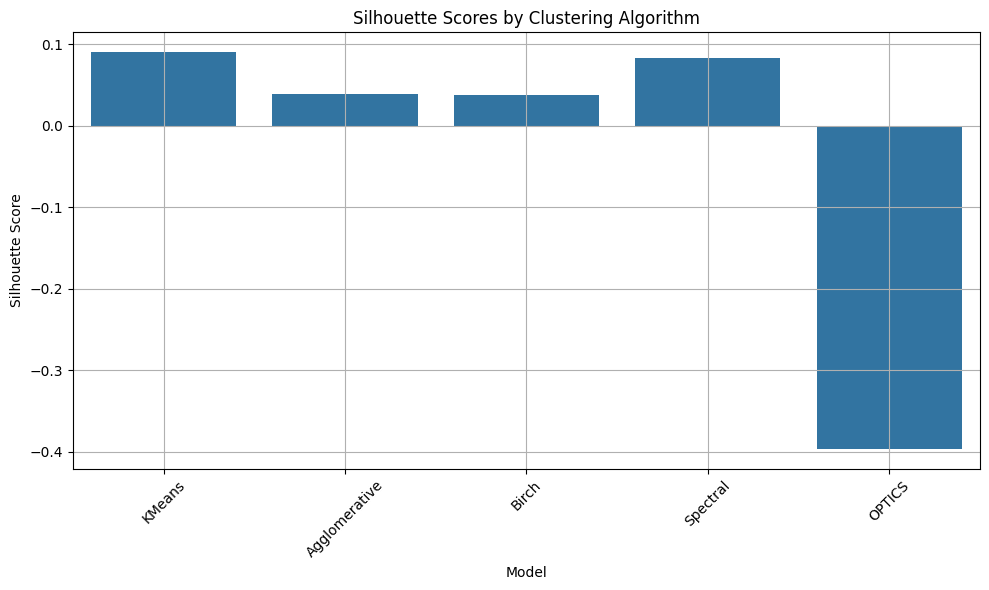

In [7]:
# Optionally, create a bar plot for Silhouette scores (excluding errors)
valid_results = results_df[results_df["Silhouette Score"] != "NA"]
if not valid_results.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=valid_results, x="Model", y="Silhouette Score")
    plt.title("Silhouette Scores by Clustering Algorithm")
    plt.ylabel("Silhouette Score")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ============================
# 1. Data Loading and Cleaning
# ============================
# Load the dataset from the CSV file
df = pd.read_csv("large_road_traffic_congestion_dataset.csv")

# Drop any rows with missing values (or use a more elaborate imputation strategy)
df.dropna(inplace=True)

# ============================
# 2. Feature Engineering & Data Partitioning
# ============================
# For clustering, we select relevant features. Here we use:
#  - Numerical: Traffic Volume, Vehicle Speed (km/h), Traffic Density (vehicles/km), Accidents
#  - Categorical: Weather Conditions, Road Type
# The true congestion level (e.g., Low, Moderate, etc.) is used for evaluation.
features = ["Traffic Volume", "Vehicle Speed (km/h)", "Traffic Density (vehicles/km)", "Accidents", 
            "Weather Conditions", "Road Type"]
target = "Congestion Level"

# Partition the dataset into training, validation, and testing subsets.
# Stratify by the congestion level for a balanced split.
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df[target])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[target])

print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Test set size:", test_df.shape)

# ============================
# 3. Preprocessing
# ============================
# Define numerical and categorical columns
num_cols = ["Traffic Volume", "Vehicle Speed (km/h)", "Traffic Density (vehicles/km)", "Accidents"]
cat_cols = ["Weather Conditions", "Road Type"]

# Create a preprocessor: scale numerical features and one-hot encode categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols)
    ]
)

# Fit the preprocessor on the training data and transform training, validation, and test features
X_train = preprocessor.fit_transform(train_df[features])
X_val   = preprocessor.transform(val_df[features])
X_test  = preprocessor.transform(test_df[features])

# Extract ground truth congestion levels
y_train = train_df[target].values
y_val   = val_df[target].values
y_test  = test_df[target].values

# ============================
# 4. K-Means Clustering and Model Training
# ============================
    # For this example, we use K-Means clustering to group traffic patterns.
    # We set the number of clusters equal to the number of unique congestion level labels.
n_clusters = len(np.unique(y_train))
train_f1 = []
val_f1 = []
epochs = np.arange(1, n_clusters + 200, 1)
for i in range(1, n_clusters + 200):
    kmeans = KMeans(n_clusters=i, random_state=42)
    # Fit the model on the training data
    kmeans.fit(X_train)

    # Get predicted cluster assignments for each dataset
    train_clusters = kmeans.predict(X_train)
    val_clusters   = kmeans.predict(X_val)
    test_clusters  = kmeans.predict(X_test)

    # ============================
    # 5. Mapping Clusters to True Labels and Evaluation
    # ============================
    # Since clustering is unsupervised, cluster indices have no inherent meaning.
    # We map each cluster to a congestion level label by assigning the most common true label from the training data.

    def map_clusters_to_labels(clusters, true_labels):
        """
        Maps each unique cluster to the most common true label from the training set.
        """
        mapping = {}
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            indices = np.where(clusters == cluster)[0]
            most_common = pd.Series(true_labels[indices]).mode()[0]
            mapping[cluster] = most_common
        return mapping

    # Create mapping using the training set
    cluster_mapping = map_clusters_to_labels(train_clusters, y_train)

    def map_predictions(clusters, mapping):
        """
        Applies the cluster-to-label mapping to an array of predicted clusters.
        """
        return np.array([mapping.get(cluster, "Unknown") for cluster in clusters])

    # Map cluster predictions to congestion level labels
    y_train_pred = map_predictions(train_clusters, cluster_mapping)
    y_val_pred   = map_predictions(val_clusters, cluster_mapping)
    y_test_pred  = map_predictions(test_clusters, cluster_mapping)

    # Evaluate the clustering performance on the test set using classification metrics
    print(f"Test Set Evaluation Metrics:{i} Clusters")
    # print(classification_report(y_test, y_test_pred))
    print(f"f1_score: {f1_score(y_test, y_test_pred, average='weighted')}")
    train_f1.append(f1_score(y_train, y_train_pred, average='weighted'))

    # Optionally, also evaluate on the validation set
    print(f"Validation Set Evaluation Metrics:{i} Clusters")
    # print(classification_report(y_val, y_val_pred))
    print(f"f1_score: {f1_score(y_val, y_val_pred, average='weighted')}")
    val_f1.append(f1_score(y_val, y_val_pred, average='weighted'))


Training set size: (6000, 10)
Validation set size: (2000, 10)
Test set size: (2000, 10)
Test Set Evaluation Metrics:1 Clusters
f1_score: 0.1672503748125937
Validation Set Evaluation Metrics:1 Clusters
f1_score: 0.16681252343457068
Test Set Evaluation Metrics:2 Clusters
f1_score: 0.25360504319929983
Validation Set Evaluation Metrics:2 Clusters
f1_score: 0.2724555045381279
Test Set Evaluation Metrics:3 Clusters
f1_score: 0.31938555171112787
Validation Set Evaluation Metrics:3 Clusters
f1_score: 0.3346848808067808
Test Set Evaluation Metrics:4 Clusters
f1_score: 0.3035702090163147
Validation Set Evaluation Metrics:4 Clusters
f1_score: 0.3320850797188411
Test Set Evaluation Metrics:5 Clusters
f1_score: 0.27179316339311976
Validation Set Evaluation Metrics:5 Clusters
f1_score: 0.26824504898057583
Test Set Evaluation Metrics:6 Clusters
f1_score: 0.3279025810377873
Validation Set Evaluation Metrics:6 Clusters
f1_score: 0.34371716591161655
Test Set Evaluation Metrics:7 Clusters
f1_score: 0.334

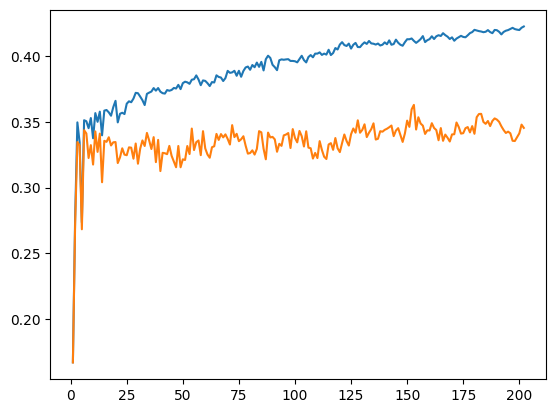

In [17]:
import matplotlib.pyplot as plt
plt.plot(epochs, train_f1, label='Train F1 Score')
plt.plot(epochs, val_f1, label='Validation F1 Score')
plt.show()

In [18]:
# Find the index of the highest validation F1 score
best_index = np.argmax(val_f1)

# Get the number of clusters corresponding to the highest validation F1 score
best_n_clusters = epochs[best_index]
print(f"The number of clusters with the highest validation F1 score is: {best_n_clusters}")

The number of clusters with the highest validation F1 score is: 153
